In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
from pymongo import MongoClient

In [2]:
client = MongoClient('localhost', 27017)
db = client.moniter_crowdfunding
project = db.projects
f_project = db.failure_projects

In [3]:
num_Psucc = project.count_documents({'状态': '项目成功'})
num_Csucc = project.count_documents({'状态': '众筹成功'})
num_Cing = project.count_documents({'状态': '众筹中'})
num_Fproj = f_project.count_documents({})
print(f'项目成功:{num_Psucc}', f'众筹成功:{num_Csucc}', f'众筹中:{num_Cing}', f'项目失败:{num_Fproj}', sep='\t')

项目成功:803	众筹成功:172	众筹中:219	项目失败:411


In [13]:
def increment(x):
    return [(x[i] - x[i-1]) if i >= 1 else x[0] for i in range(len(x))]

### 对单条众筹成功项目的数据处理

In [4]:
succ_projs = project.find({"状态": '项目成功'})

In [28]:
item = succ_projs[10]
start_time = item['状态变换时间1-2']
end_time = item['状态变换时间2-3']

print(f"项目编号: {item['_id']}\n项目名称: {item['项目名称']}\n所属类别: {item['所属类别']}\n公司名称: {item['公司名称']}")
print(f"\n众筹期限: {item['众筹期限']}\n项目状态: {item['状态']}")
print()
print("发起人页面:", f"http://z.jd.com/project/details/{item['_id']}.html") 
print("项目页面:", f"http://z.jd.com{item['发起人链接']}")
print()
print('预热中:', item['状态变换时间0-1'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t') 
print('预热中->众筹中:', start_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->众筹成功:', end_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->项目成功:', item['状态变换时间3-4'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')

项目编号: 97064
项目名称: 品客智能净水热饮一体机
所属类别: 智能家居
公司名称: 浙江品客智能科技股份有限公司

众筹期限: 40
项目状态: 项目成功

发起人页面: http://z.jd.com/project/details/97064.html
项目页面: http://z.jd.com/funderCenter.action?flag=2&id=97064

预热中:	2018年04月28日 10:11:06
预热中->众筹中:	2018年05月01日 10:00:18
众筹中->众筹成功:	2018年06月20日 12:00:04
众筹中->项目成功:	2018年07月11日 06:00:04


- 扩散图

In [115]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    start_t = item['状态变换时间1-2']  # 众筹开始时间
    end_t = item['状态变换时间2-3']  # 众筹成功时间

    # 去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2

    # 绘图
    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [116]:
df = to_df(item)

众筹开始时间: 2018年05月01日
众筹结束时间: 2018年06月20日
更新次数:460


In [114]:
pd.Timedelta('5:40:1')

Timedelta('0 days 05:40:01')

In [90]:
start_t

datetime.datetime(2018, 5, 1, 10, 0, 18, 668000)

pandas._libs.tslibs.timestamps.Timestamp

In [106]:
d = data.iloc[0].name

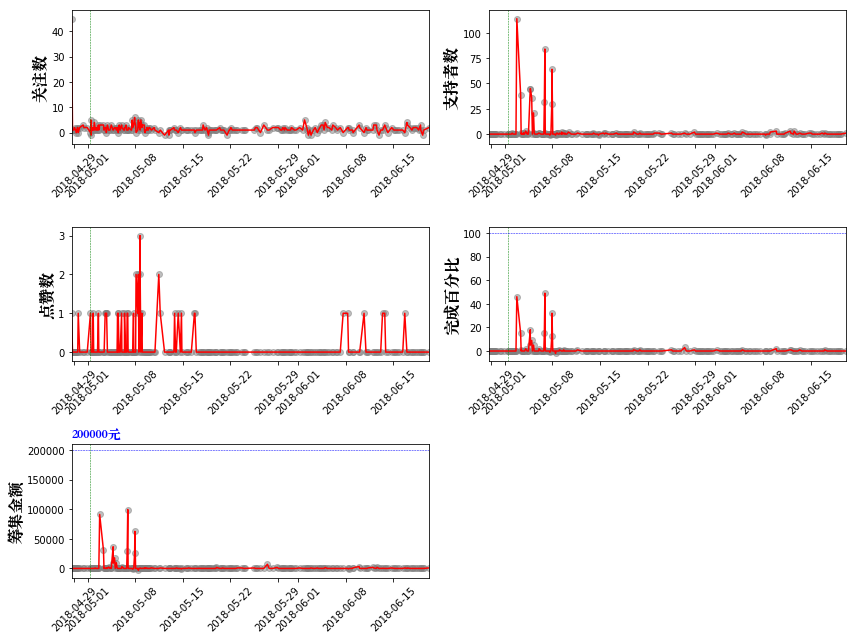

In [30]:
fig = plt.figure(figsize=(12, 9))
myfont = mpl.font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")
mpl.rcParams['axes.unicode_minus'] = False
for i, col in enumerate(col_names, start=1):
    ax = fig.add_subplot(3, 2, i)
    ax.plot(data.index, increment(data[col]), 'r-')
    ax.scatter(data.index.values, increment(data[col].values), color='grey', alpha=0.5)
    ax.set_ylabel(col, fontproperties=myfont, fontsize=16)
    ax.set_xlim([data.index.values[0], data.index.values[-1]])
    ax.axvline(start_t, color='green', linestyle='--', linewidth=0.5)
    ax.axvline(end_t, color='red', linestyle='--', linewidth=0.5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if i == 4:
        ax.axhline(100, color='blue', linestyle='--', linewidth=0.5)
    
    if i == 5:
        ax.axhline(t_fund, color='blue', linestyle='--', linewidth=0.5)
        ax.text(data.index.values[0], t_fund*1.1, f"{t_fund}元", fontproperties=myfont, fontsize=13, color='blue')
        
fig.tight_layout()

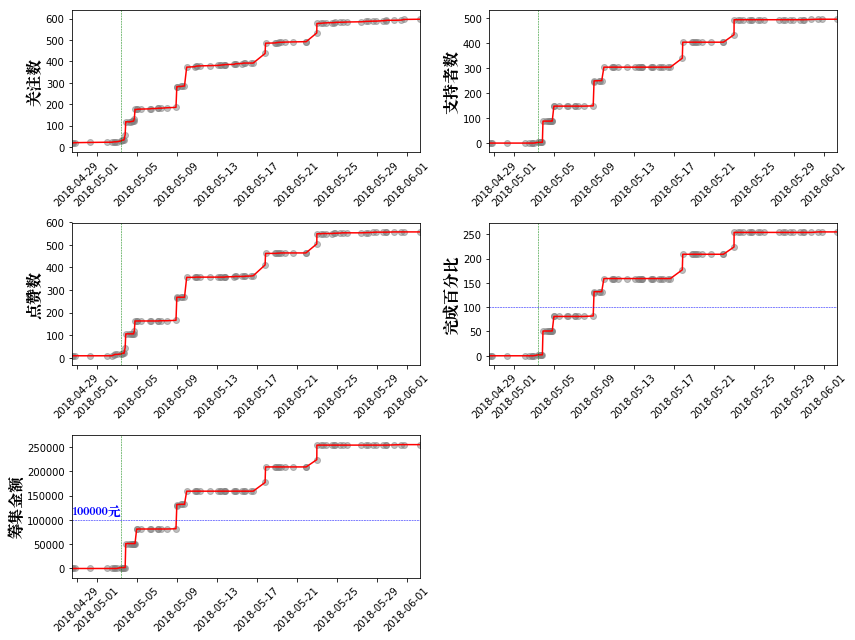

In [12]:
fig = plt.figure(figsize=(12, 9))
myfont = mpl.font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")
mpl.rcParams['axes.unicode_minus'] = False
for i, col in enumerate(col_names, start=1):
    ax = fig.add_subplot(3, 2, i)
    ax.plot(data.index, data[col], 'r-')
    ax.scatter(data.index.values, data[col].values, color='grey', alpha=0.5)
    ax.set_ylabel(col, fontproperties=myfont, fontsize=16)
    ax.set_xlim([data.index.values[0], data.index.values[-1]])
    ax.axvline(start_t, color='green', linestyle='--', linewidth=0.5)
    ax.axvline(end_t, color='red', linestyle='--', linewidth=0.5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if i == 4:
        ax.axhline(100, color='blue', linestyle='--', linewidth=0.5)
    
    if i == 5:
        ax.axhline(t_fund, color='blue', linestyle='--', linewidth=0.5)
        ax.text(data.index.values[0], t_fund*1.1, f"{t_fund}元", fontproperties=myfont, fontsize=13, color='blue')
        
fig.tight_layout()

- 评论数据处理：分别选取出众筹开始前后的评论

In [106]:
review = x['评论']['评论详细']
list_review = sorted(review.items())

strpTime = datetime.datetime.strptime  # 日期字符串转换为datetime对象
before_items = [(strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S"), item[1]['评论内容']) for item in list_review 
                if strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S") <= start_time]
after_items = [(strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S"), item[1]['评论内容']) for item in list_review 
               if strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S") > start_time]

print(f'众筹开始前评论数量: {len(before_items)}\n众筹开始后评论数量: {len(after_items)}')

In [133]:
for dt, item in after_items:
    print(dt.date(), item)

2018-04-30 在日本买的1000多块小铁壶干烧了一次里面掉皮了，别人说是搪瓷涂层的，不好。这款有没有涂层
2018-04-30 日本原矿铁砂，好吗？先不说日本矿产资源的匮乏，就是这种媚外的感觉，看见这就想骂人。
2018-05-02 实心提梁烫手吗
2018-05-15 确定是日本“砂铁”？我可是研究砂铁出身的，经得起检验吗？
2018-05-22 可以开发票的吗？
2018-05-25 会不会生锈？


### 分析众筹成功项目

In [32]:
succ_project = project.find({'状态': '项目成功'})

In [33]:
print('预热中:', succ_project[1]['状态变换时间0-1'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t') 
print('预热中->众筹中:', succ_project[1]['状态变换时间1-2'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->众筹成功:', succ_project[1]['状态变换时间2-3'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->项目成功:', succ_project[1]['状态变换时间3-4'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')

预热中:	2018年04月28日 10:11:06
预热中->众筹中:	2018年04月28日 14:00:18
众筹中->众筹成功:	2018年05月23日 15:29:58
众筹中->项目成功:	2018年06月28日 06:00:02


- 项目成功时间
> 查看从众筹开始到众筹成功的时间分布。

In [ ]:
def get_status():
    
    return

In [33]:
x = project.find_one({}).keys()

In [36]:
for d in sorted(list(x)):
    print(d)

_id
众筹期限
公司名称
公司地址
公司工作时间
公司电话
发起人名称
发起人链接
各档动态信息
各档基础信息
所属类别
爬取次数
状态
状态变换时间0-1
状态变换时间1-2
状态变换时间2-3
状态变换时间3-4
目标金额
评论
项目动态信息
项目名称


In [39]:
project.find_one({'状态': "项目成功"}, projection={"项目动态信息":0, "各档基础信息":0, "各档动态信息":0, "评论":0})

{'_id': '99981',
 '状态变换时间0-1': datetime.datetime(2018, 4, 28, 10, 11, 6, 380000),
 '状态': '项目成功',
 '爬取次数': 476,
 '众筹期限': 30,
 '公司名称': '厦门逸道电子商务有限公司',
 '公司地址': '福建厦门市湖里区\xa0\xa0安岭二路87号9008室D单元',
 '公司工作时间': '周一至周日 09:00-22:00',
 '公司电话': '021-66530779',
 '发起人名称': '逸道茶具专营店',
 '发起人链接': '/funderCenter.action?flag=2&id=99981',
 '所属类别': '原创设计',
 '目标金额': 50000,
 '项目名称': '匠心之作-龙善堂铁壶-雨龙',
 '状态变换时间1-2': datetime.datetime(2018, 4, 29, 10, 0, 22, 969000),
 '状态变换时间2-3': datetime.datetime(2018, 5, 29, 11, 53, 16, 232000),
 '状态变换时间3-4': datetime.datetime(2018, 6, 27, 6, 0, 3, 533000)}

In [115]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    start_t = item['状态变换时间1-2']  # 众筹开始时间
    end_t = item['状态变换时间2-3']  # 众筹成功时间

    # 去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2

    # 绘图
    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [111]:
def getTimeRange(df)
    x = df[df.index > start_t]
    y = x[x.完成百分比.values > 100]
    d = x[:y.index[0]]
    return d